# Поиск сигнальных событий на $\phi$-мезоне

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uproot
import numpy as np
import pandas as pd
import pylib.style as pl

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [87]:
df_signal = pd.read_csv('../data/12_omega/results/signal.csv', index_col=0)[['n_sig_exp', 'n_sig_exp_err', 'n_sig_mc', 'n_sig_mc_err', 'emeas']]
df_lum = pd.read_csv('../data/12_omega/results/lum.csv', index_col=0)[['lum']]
df_trigs = pd.read_csv('../data/12_omega/results/triggers.csv', index_col=0)[['eff_trig', 'eff_trig_err']]

In [88]:
df_signal = df_signal.join(df_lum).join(df_trigs)
df_signal['n_sig_mc'] /= 20000
df_signal['n_sig_mc_err'] /= 20000
df_signal.emeas *= 2

In [90]:
df_signal['corr'] = pd.Series({
    507.: 0.71*0.987,
    508.: 0.7*0.985,
    509.: 0.73*1.024,
    510.: 0.83*0.994,
    512.: 1.08*0.996,
    514.: 1.26*0.998,
    525.: 1.79,
})
df_signal['cs0'] = pd.Series({
    507.: 219.53,
    508.: 624.76,
    509.: 1434.84,
    510.: 807.54,
    512.: 199.26,
    514.: 96.96,
    525.: 17.47,
})
df_signal['cs0_err'] = pd.Series({
    507.: 5.02,
    508.: 9.89,
    509.: 18.40,
    510.: 10.36,
    512.: 4.97,
    514.: 3,
    525.: 0.94,
})

In [91]:
df_signal['cs'] = df_signal['n_sig_exp']/df_signal['lum']/df_signal['n_sig_mc']/df_signal['eff_trig']/df_signal['corr']
sqr_f = lambda col: (df_signal[f'{col}_err']/df_signal[col])**2
df_signal['cs_err'] = df_signal['cs']*np.sqrt( sqr_f('n_sig_exp') + sqr_f('n_sig_mc') + sqr_f('eff_trig') )

In [92]:
df_signal

,n_sig_exp,n_sig_exp_err,n_sig_mc,n_sig_mc_err,emeas,lum,eff_trig,eff_trig_err,corr,cs0,cs0_err,cs,cs_err
507.0,2145.371808,52.776384,0.207548,0.003222,1015.087097,70.5469,0.977667,0.005502,0.70077,219.53,5.02,213.865118,6.336190
508.0,5568.999984,74.613434,0.212582,0.003260,1017.171997,60.8262,0.969341,0.004131,0.68950,624.76,9.89,644.390820,13.406633
509.0,10872.000242,105.627028,0.217447,0.003297,1019.088562,52.9112,0.964363,0.003265,0.74752,1434.84,18.40,1310.823786,24.020021
510.0,8220.002368,83.286535,0.214699,0.003276,1021.374329,58.9441,0.968443,0.003622,0.82502,807.54,10.36,812.947126,15.198706
512.0,2558.129034,58.939913,0.227903,0.003376,1025.427490,57.4664,0.970010,0.006135,1.07568,199.26,4.97,187.196885,5.262341
514.0,1337.069583,47.361819,0.213884,0.003270,1029.092651,55.5566,0.946064,0.012281,1.25748,96.96,3.00,94.584311,3.850166
525.0,697.218332,89.619882,0.124596,0.002496,1050.750122,197.4100,0.959423,0.013951,1.79000,17.47,0.94,16.505617,2.160600


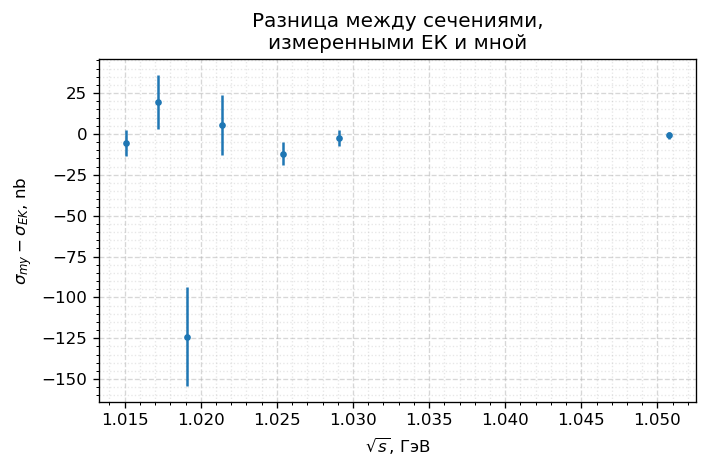

In [105]:
# plt.errorbar(df_koz.emeas, df_koz.cs_born, df_koz.cs_born_err, fmt='.', ms=1)
plt.errorbar(df_signal.emeas*1e-3, df_signal.cs - df_signal.cs0, np.sqrt(df_signal.cs_err**2 + df_signal.cs0_err**2), fmt='.')
pl.my_style('Разница между сечениями,\nизмеренными ЕК и мной', '$\sqrt{s}$, ГэВ', '$\\sigma_{my} - \\sigma_{EK}$, nb')
# plt.savefig('../docs/sources/study/cs_diffs.png', dpi=100)
# plt.yscale('log')

In [12]:
dfExp = uproot.open('../trees/exp2012omega.root')['t'].pandas.df()
dfMC  = uproot.open('../trees/mc_mcgpj12omega.root')['t'].pandas.df()

In [13]:
dfExp['ebeam'] = dfExp.name.astype(str).str.extract(r'_e(\d+.?\d*)_', expand=False).astype(float)
dfMC['ebeam'] = dfMC.name.astype(str).str.extract(r'_(\d+.?\d*)_', expand=False).astype(float)
dfMC['runnum'] = dfMC.name.astype(str).str.extract(r'_(\d+).root', expand=False).astype(int)

In [14]:
dfMC.loc[dfMC.runnum==17451, 'ebeam'] = 511.1
dfExp.loc[dfExp.ebeam>5000, 'ebeam'] = 511.1
dfExp.drop('name', axis=1, inplace=True)
dfMC.drop('name', axis=1, inplace=True)

In [15]:
dfExp = dfExp.set_index('ebeam')
dfMC = dfMC.set_index('ebeam')

In [16]:
dfExp.index.unique()

Float64Index([507.0, 508.0, 509.0, 510.0, 511.1, 511.0, 512.0, 514.0, 525.0], dtype='float64', name='ebeam')

In [133]:
e0, nMC = 514, 20000
dfE = dfExp.loc[e0]
dfM = dfMC.loc[e0]
phi =  0.205/(e0*2e-3-0.732) + 0.14

In [134]:
dfE.emeas.unique()*2

array([1029.0898], dtype=float32)

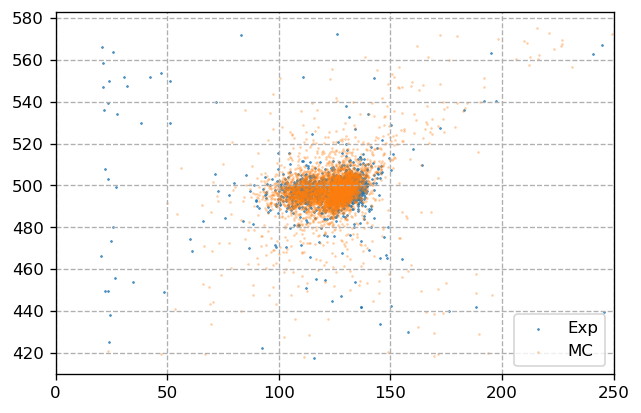

In [135]:
plt.grid(ls='--')
plt.scatter(dfE.ksptot, dfE.ksminv, marker='.', s=1, label='Exp');
plt.scatter(dfM.ksptot, dfM.ksminv, marker='.', s=1, alpha=0.4, label='MC');
plt.xlim(0, 250)
plt.legend();

In [136]:
mKs= 497.6
p0 = np.sqrt(e0**2 - mKs**2)
dfE = dfE.assign(x1=(dfE.ksminv - mKs)*np.cos(phi))
dfE = dfE.assign(x2=(dfE.ksptot - p0)*np.sin(phi))

In [137]:
dfM = dfM.assign(x1=(dfM.ksminv - mKs)*np.cos(phi))
dfM = dfM.assign(x2=(dfM.ksptot - p0)*np.sin(phi))

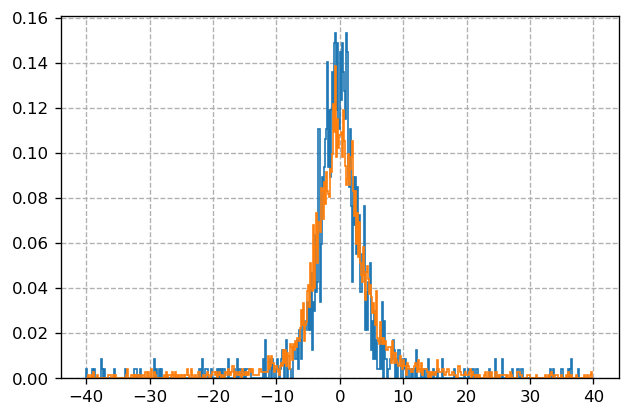

In [138]:
plt.grid(ls='--')
plt.hist(dfE.x1, bins=500, range=(-40, 40), histtype='step', density=True);
plt.hist(dfM.x1, bins=500, range=(-40, 40), histtype='step', density=True);

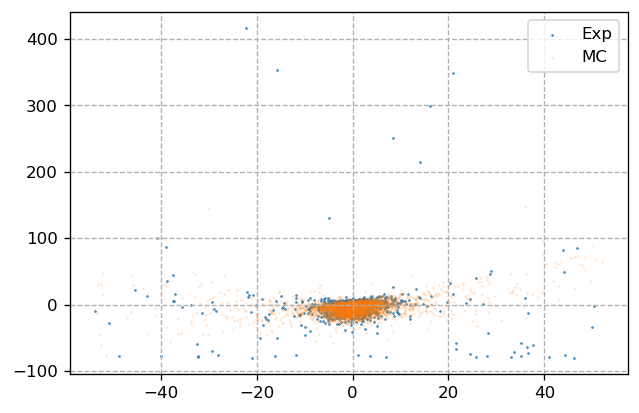

In [139]:
plt.grid(ls='--')
plt.scatter(dfE.x1, dfE.x2, marker='.', s=1, label='Exp');
plt.scatter(dfM.x1, dfM.x2, marker='.', s=1, alpha=0.2, label='MC');
# plt.xlim(0, 250)
plt.legend();

[iminuit notebook](https://nbviewer.ipython.org/github/scikit-hep/iminuit/blob/master/tutorial/cost_functions.ipynb)

In [140]:
import numba as nb
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL, ExtendedBinnedNLL, LeastSquares
from argparse import Namespace

In [141]:
width = 80
dt = dfE.x1.values
dt = dt[abs(dt)<width/2]

In [142]:
kwd = {"parallel": False, "fastmath": True}

@nb.njit(**kwd)
def signal_pdf(x, mu, sigma):
    z = (x - mu) / sigma
    invnorm = 1 / ( np.sqrt(2 * np.pi) * sigma )
    signal = np.exp(-(z**2)/2) * invnorm
    return signal

@nb.njit(**kwd)
def norm_pdf(x, mu, sigma1, sigma2, f, fs):
    sig1 = signal_pdf(x, mu, sigma1)
    sig2 = signal_pdf(x, mu, sigma2)
    bkg = 1/width
    return f*( fs*sig1 + (1-fs)*sig2 ) + (1-f)*bkg

In [143]:
m = Minuit(ExtendedUnbinnedNLL(dt, lambda x, n, mu, sigma1, sigma2, f, fs: (n, n * norm_pdf(x, mu, sigma1, sigma2, f, fs))),
                       n=1000, mu=0, sigma1=2, sigma2=5, f=0.99,
                       limit_mu=(-2, 2),
                       limit_sigma1=(0,None),
                       limit_sigma2=(0,None),
                       limit_n=(0, None),
                       limit_f=(0, 1),
                       limit_fs=(0, 1),
          )

In [144]:
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -4972                      │       Ncalls = 178 (178 total)       │
│ EDM = 3.79e-05 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n      │  1.47e3   │  0.04e3   │            │            │    0    │         │       │
│ 1 │ mu     │   -0.11   │   0.08    │            │            │   -2    │    2    │       │
│ 2 │ sigma1 │   2.35    │   0.14    │            │            │    0    │         │       │
│ 3 │ sigma2 │    5.7    │    0.7    │            │            │    0    │         │       │
│ 4 │ f      │   0.931   │   0.010   │            │            │    0    │    1    │       │
│ 5 │ fs     │   0.74    │   0.07    │            │            │    0    │    1    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

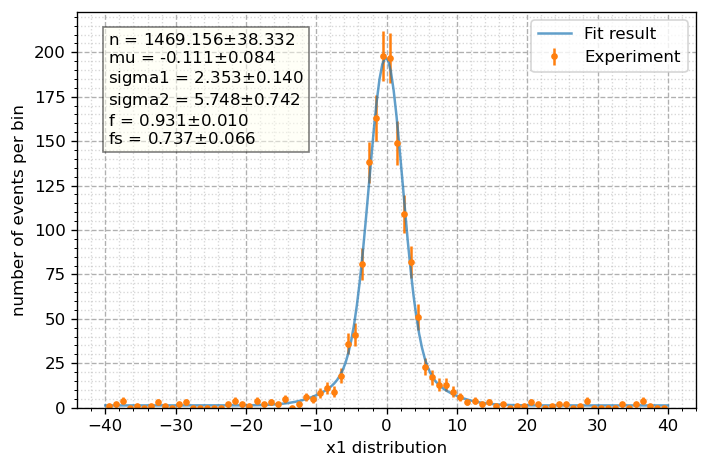

In [145]:
pl.plot_fit(dt, norm_pdf, m, 80, (-40, 40), errors=True, label='Experiment', xtitle='x1 distribution',
           ytitle='number of events per bin')
# plt.savefig('pic3.png')

In [146]:
N0 = (m.values['n']*m.values['f'], m.errors['n'])

Эфффективность регистрации

In [147]:
mcdata = dfM.x1.values
mcdata = mcdata[abs(mcdata)<width/2]

In [148]:
mMC = Minuit(ExtendedUnbinnedNLL(mcdata, lambda x, n, mu, sigma1, sigma2, f, fs: (n, n * norm_pdf(x, mu, sigma1, sigma2, f, fs))),
                       n=1000, mu=0, sigma1=2, sigma2=5, f=0.99,
                       limit_mu=(-2, 2),
                       limit_sigma1=(0,None),
                       limit_sigma2=(0,None),
                       limit_n=(0, None),
                       limit_f=(0, 1),
                       limit_fs=(0, 1),
          )
mMC.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.952e+04                 │       Ncalls = 252 (252 total)       │
│ EDM = 2.12e-05 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n      │  4.52e3   │  0.06e3   │            │            │    0    │         │       │
│ 1 │ mu     │   -0.04   │   0.06    │            │            │   -2    │    2    │       │
│ 2 │ sigma1 │   3.18    │   0.08    │            │            │    0    │         │       │
│ 3 │ sigma2 │   10.0    │    0.8    │            │            │    0    │         │       │
│ 4 │ f      │   0.955   │   0.007   │            │            │    0    │    1    │       │
│ 5 │ fs     │   0.814   │   0.019   │            │            │    0    │    1    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

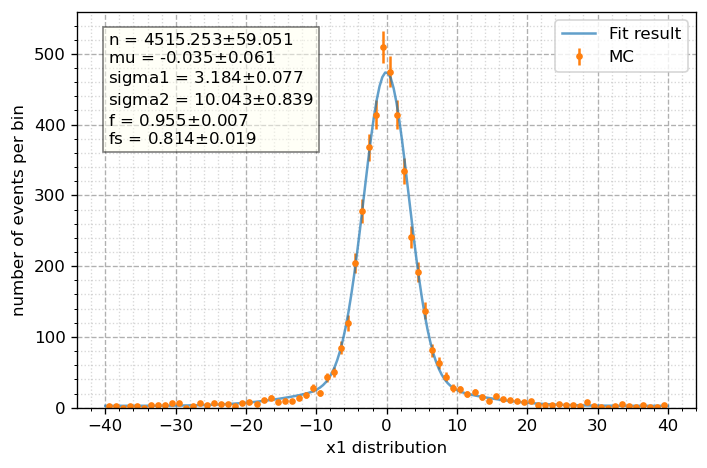

In [149]:
pl.plot_fit(mcdata, norm_pdf, mMC, 80, (-40, 40), errors=True, label='MC', xtitle='x1 distribution',
           ytitle='number of events per bin')

In [150]:
NMC = (mMC.values['n']*mMC.values['f']/20000, mMC.errors['n']/20000)

In [151]:
# NMC = mcdata.size/20000, np.sqrt(mcdata.size)/20000

In [152]:
NMC

(0.2155947111669207, 0.002952540221502727)

Эффективность триггера

In [153]:
tab = dfE.query('abs(x1)<@width/2')

In [154]:
trigdf = pd.pivot_table( tab[['trigbits']].assign(ones=1), values='ones', columns='trigbits', aggfunc='sum').\
            rename({1: 'T', 2: 'C', 3:'TC'}, axis=1)

In [155]:
t, c, tc = trigdf['T']+trigdf['TC'], trigdf['C']+trigdf['TC'], trigdf['TC']

trigdf['effT'] = (tc + 1)/(c + 2)
trigdf['effC'] = (tc + 1)/(t + 2)

trigdf['errT'] = np.sqrt( (tc+1)*(tc+2)/(c+2)/(c+3) - ((tc+1)/(c+2))**2 )
trigdf['errC'] = np.sqrt( (tc+1)*(tc+2)/(t+2)/(t+3) - ((tc+1)/(t+2))**2 )

trigdf['eff']  = 1 - (1-trigdf.effT)*(1-trigdf.effC)
trigdf['err']  = np.sqrt( (trigdf.errT*(1-trigdf.effC))**2 
                         + (trigdf.errC*(1-trigdf.effT))**2 )

In [156]:
trigdf

trigbits,T,C,TC,effT,effC,errT,errC,eff,err
ones,1177,20,272,0.928571,0.188146,0.014995,0.010257,0.94201,0.012195


In [157]:
effT = trigdf.iloc[0][['eff', 'err']].values

Посмотрим

In [158]:
dfE.index[0]

514.0

In [159]:
dfE.emeas.unique()*2

array([1029.0898], dtype=float32)

In [160]:
# lum, rad, enspr = [58.9441, 0.367584], 0.83, 0.994 #510 MeV
# lum, rad, enspr = [52.9112, 0.347086], 0.72, 1.022 #509 MeV
lum, rad, enspr = [55.5566, 0.359233], 1.26, 0.998 #514 MeV

In [161]:
N0, NMC, effT

((1368.295253837097, 38.33161324031596),
 (0.2155947111669207, 0.002952540221502727),
 array([0.94201044, 0.01219539]))

In [162]:
cs = (N0[0]/NMC[0]/effT[0]/lum[0]/rad)*enspr

In [163]:
cs_err = cs*np.sqrt( (N0[1]/N0[0])**2 + (NMC[1]/NMC[0])**2 +
                    (effT[1]/effT[0])**2 )

In [164]:
cs, cs_err

(96.0528687420789, 3.2430376963638077)

Результат:

$E_{c.m.}$, MeV | $\sigma$, nb | $\sigma_0$, nb 
--- | --- | ---
1019.214 | 1390.1 $\pm$ 25.3 | 1433.05 $\pm$ 15.03
1021.309 | 800.2 $\pm$ 15.5 | 807.54 $\pm$ 10.36
1029.09 | 96.1 $\pm$ 3.2 | 96.96 $\pm$ 3.00

In [165]:
arr = np.array([
[1019.214, 1390.1, 25.3, 1433.05, 15.03],
[1021.309, 800.2, 15.5, 807.54, 10.36],
[1029.09, 96.1, 3.22, 96.96, 3.00],
]).T

In [166]:
arr

array([[1019.214, 1021.309, 1029.09 ],
       [1390.1  ,  800.2  ,   96.1  ],
       [  25.3  ,   15.5  ,    3.22 ],
       [1433.05 ,  807.54 ,   96.96 ],
       [  15.03 ,   10.36 ,    3.   ]])

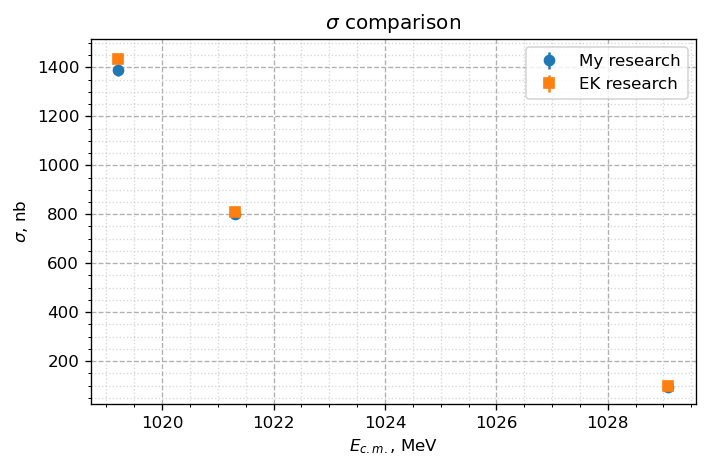

In [168]:
plt.errorbar(arr[0], arr[1], yerr=arr[2], fmt='o', label='My research')
plt.errorbar(arr[0], arr[3], yerr=arr[4], fmt='s', label='EK research')
pl.my_style('$\\sigma$ comparison', '$E_{c.m.}$, MeV', '$\\sigma$, nb', legend=True)
# plt.savefig('рис1.png')

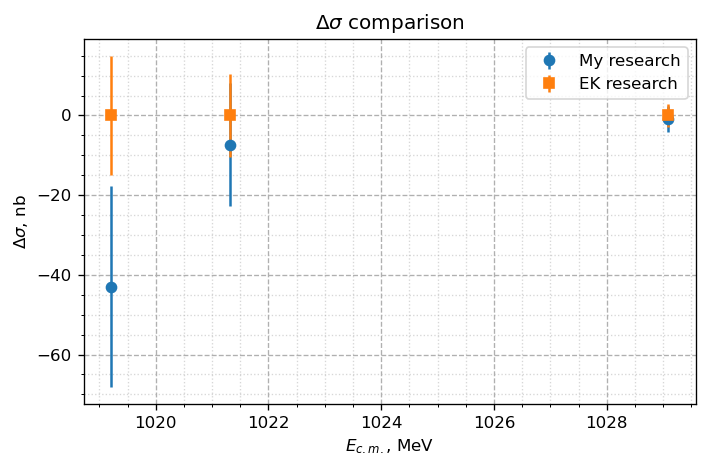

In [169]:
plt.errorbar(arr[0], arr[1]-arr[3], yerr=arr[2], fmt='o', label='My research')
plt.errorbar(arr[0], np.zeros_like(arr[1]), yerr=arr[4], fmt='s', label='EK research')
pl.my_style('$\\Delta\\sigma$ comparison', '$E_{c.m.}$, MeV', '$\\Delta\\sigma$, nb', legend=True)
# plt.savefig('рис2.png')